In [ ]:
import cv2
import keras
import pickle
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Load cac tap du lieu de Train model
data_dir = "/content/drive/MyDrive/Dataset-Processing-Version-02"
train_data_dir = "/content/drive/MyDrive/Dataset-Processing-Version-02/train/"
validation_data_dir = "/content/drive/MyDrive/Dataset-Processing-Version-02/val/"
test_data_dir = "/content/drive/MyDrive/Dataset-Processing-Version-02/test/"

Data Training: 4050
Data Validation: 450
Data Test Model: 500
Total Dataset: 5000


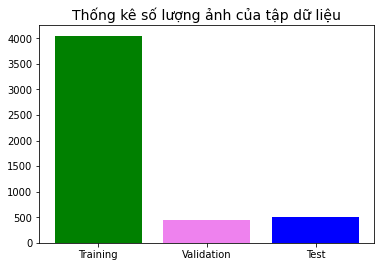

In [ ]:
#Thong ke so luong hinh anh
import time
import os
from os.path import exists
import pandas as pd

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return counter

number_data_train = count(train_data_dir)
number_data_val = count(validation_data_dir)
number_data_test = count(test_data_dir)

print("Data Training:",number_data_train)
print("Data Validation:",number_data_val)
print("Data Test Model:", number_data_test)
print("Total Dataset:", number_data_train+number_data_val+number_data_test)
x = ['Training', 'Validation', 'Test']
y = [number_data_train, number_data_val, number_data_test]
Data = {'Dataset': x,
        'Data': y}
df = pd.DataFrame(Data,columns=['Dataset','Data'])

New_Colors = ['green','violet','blue']
plt.bar(df['Dataset'], df['Data'], color=New_Colors, width = 0.8)
plt.title('Thống kê số lượng ảnh của tập dữ liệu', fontsize=14)
plt.show()

In [ ]:
# Tang cuong du lieu, giam Overfitting
datagen = ImageDataGenerator(
  featurewise_center=False, # Dat gia tri dau vao thanh 0 tren tap du lieu
  samplewise_center=False, # Dat gia tri trung binh cua moi mau thanh 0
  featurewise_std_normalization=False, # Chia dau vao cho std cua tap du lieu
  samplewise_std_normalization=False,  # Chia moi dau vao cho std cua no
  zca_whitening=False,  # apply ZCA whitening (tay trang)
  rotation_range=10,  # xoay hinh anh ngau nhien trong pham vi (do, 0 den 180) 
  zoom_range = 0.2, # Hinh anh thu phong ngau nhien
  width_shift_range=0.1,  # Dich chuyen ngau nhien hinh anh theo chieu ngang
  height_shift_range=0.1,  # Dich chuyen ngau nhien hinh anh theo chieu doc
  horizontal_flip=True,  # Dieu chinh hinh anh lat ngang
  vertical_flip=False, # Dieu chinh hinh anh lat ngau nhien 
  brightness_range=[0.2, 1.5] # Dieu chinh do sang cua anh
)

In [ ]:
# Dieu chinh kich thuoc anh, so batch_size
width = 224
height = 224
batch_size = 32

In [ ]:
train_generator = datagen.flow_from_directory(  
  train_data_dir,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True,
  seed=123
)

validation_generator = datagen.flow_from_directory(  
  validation_data_dir,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True,
  seed=123
)

Found 4050 images belonging to 5 classes.
Found 450 images belonging to 5 classes.


In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

n_class = 5
def get_model():
    # Tạo base model
    base_model_mobilenet_v2 = MobileNetV2(
        include_top=False, 
        weights="imagenet", 
        input_shape=(224,224,3)
    )
    # Tạo model chính
    x = base_model_mobilenet_v2.output
    # Add some new Fully connected layers to
    x = GlobalMaxPooling2D()(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu', name='fc2')(x)
    x = Dropout(0.25)(x)
    outs = Dense(5, activation='softmax', name='predictions')(x)

    # Đóng băng các layer của base_model
    for layer in base_model_mobilenet_v2.layers:
        layer.trainable = False

    model = Model(inputs=base_model_mobilenet_v2.inputs, outputs= outs)
    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

mobilenet_v2_model = get_model()

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenet_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
epochs = 10
History = mobilenet_v2_model.fit_generator(
  generator=train_generator,
  steps_per_epoch=len(train_generator),
  validation_data=validation_generator,
  validation_steps=len(validation_generator),
  epochs=epochs
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
127/127 [==============================] - 1299s 10s/step - loss: 1.4734 - accuracy: 0.5370 - val_loss: 0.8164 - val_accuracy: 0.6600
Epoch 2/10
127/127 [==============================] - 219s 2s/step - loss: 0.8673 - accuracy: 0.6281 - val_loss: 0.8099 - val_accuracy: 0.6578
Epoch 3/10
127/127 [==============================] - 217s 2s/step - loss: 0.8387 - accuracy: 0.6375 - val_loss: 0.7237 - val_accuracy: 0.6844
Epoch 4/10
127/127 [==============================] - 215s 2s/step - loss: 0.8106 - accuracy: 0.6415 - val_loss: 0.7218 - val_accuracy: 0.6800
Epoch 5/10
127/127 [==============================] - 216s 2s/step - loss: 0.7982 - accuracy: 0.6538 - val_loss: 0.7226 - val_accuracy: 0.6533
Epoch 6/10
127/127 [==============================] - 216s 2s/step - loss: 0.7602 - accuracy: 0.6664 - val_loss: 0.7186 - val_accuracy: 0.6800
Epoch 7/10
127/127 [==============================] - 215s 2s/step - loss: 0.7792 - accuracy: 0.6583 - val_loss: 0.7573 - val_accuracy: 0.68

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(height, width), 
  batch_size = batch_size,
  class_mode='categorical', 
  shuffle=False
)

Found 500 images belonging to 5 classes.


In [ ]:
loss, accuracy = mobilenet_v2_model.evaluate(test_generator, verbose=2)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

16/16 - 139s - loss: 0.6539 - accuracy: 0.7160 - 139s/epoch - 9s/step
Test accuracy : 0.7160000205039978
Test loss : 0.6538892984390259


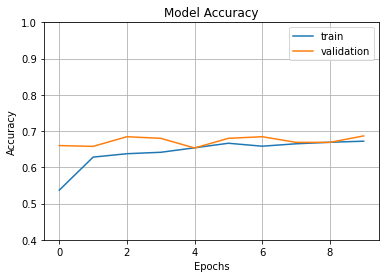

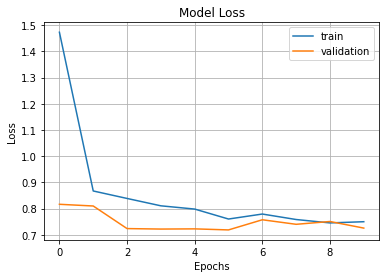

In [ ]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

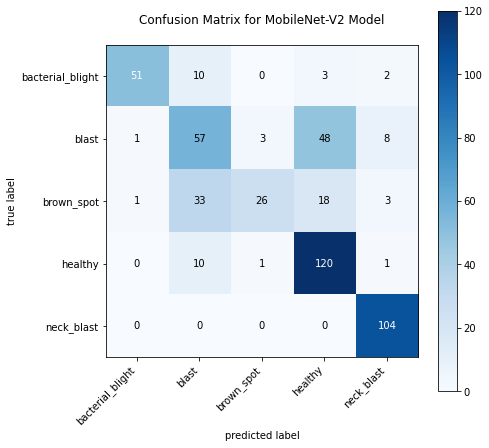

                  precision    recall  f1-score   support

bacterial_blight     0.9623    0.7727    0.8571        66
           blast     0.5182    0.4872    0.5022       117
      brown_spot     0.8667    0.3210    0.4685        81
         healthy     0.6349    0.9091    0.7477       132
      neck_blast     0.8814    1.0000    0.9369       104

        accuracy                         0.7160       500
       macro avg     0.7727    0.6980    0.7025       500
    weighted avg     0.7396    0.7160    0.6988       500



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_name = list(test_generator.class_indices)
predictions = mobilenet_v2_model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
y_target = class_name

matc=confusion_matrix(y_real, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=matc, figsize=(7,7), colorbar=True)

ax.set_title('Confusion Matrix for MobileNet-V2 Model')

ax.set_xticklabels([''] + list(np.unique(y_target)), rotation=45, fontsize=10, ha='right')
ax.set_yticklabels([''] + list(np.unique(y_target)))
plt.show()

target_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']

print(metrics.classification_report(y_real,y_pred, digits = 4, target_names=target_names))

(1, 224, 224, 3)
1/1 [==============================] - 0s 89ms/step


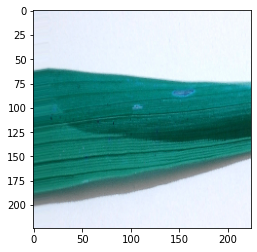

The predicted class is neck_blast


In [ ]:
#number = 101
#image_from_test_data = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02/test/blast/rice_blast_{}".format(number)+".jpg"
image_from_test_data = "/content/drive/MyDrive/Dataset-Processing-Version-02/test/bacterial_blight/bacterial_blight_172.jpg"
image=cv2.imread(image_from_test_data)
image_resized= cv2.resize(image, (224, 224))
image=np.expand_dims(image_resized, axis=0)
print(image.shape)

pred=mobilenet_v2_model.predict(image)
pred_digits=np.argmax(pred)

plt.imshow(np.squeeze(image))
plt.show()
class_name = list(test_generator.class_indices)

output_class=class_name[np.argmax(pred)]
print("The predicted class is", output_class)

In [ ]:
mobilenet_v2_model.save('/content/drive/MyDrive/Model/MobileNet_V2_Version_02.h5')

In [ ]:
from tensorflow.keras.models import load_model
mobilenet_v5_model_upload = load_model('/content/drive/MyDrive/Model/MobileNet_V2_Version_05.h5')

In [ ]:
mobilenet_v5_model_upload.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
epochs = 20
History = mobilenet_v5_model_upload.fit_generator(
  generator=train_generator,
  steps_per_epoch=len(train_generator),
  validation_data=validation_generator,
  validation_steps=len(validation_generator),
  epochs=epochs
)

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(height, width), 
  batch_size = batch_size,
  class_mode='categorical', 
  shuffle=False
)

Found 500 images belonging to 5 classes.


In [ ]:
loss, accuracy = mobilenet_v4_model_upload.evaluate(test_generator, verbose=2)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

16/16 - 37s - loss: 0.5826 - accuracy: 0.7680 - 37s/epoch - 2s/step
Test accuracy : 0.7680000066757202
Test loss : 0.5826309323310852


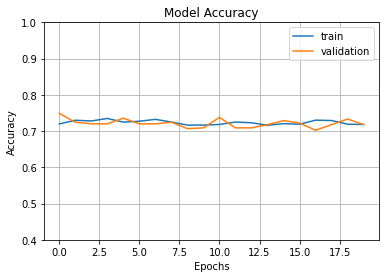

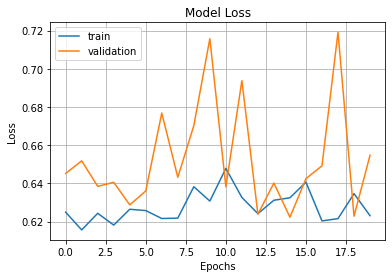

In [ ]:
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


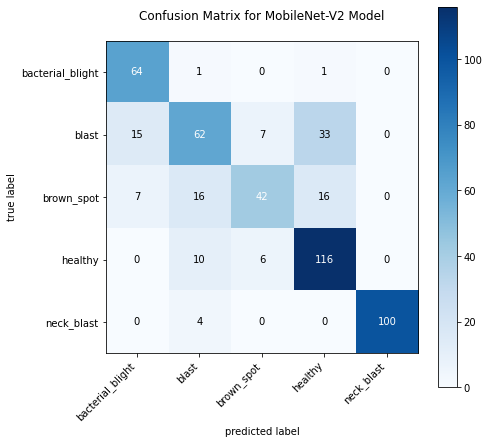

                  precision    recall  f1-score   support

bacterial_blight       0.74      0.97      0.84        66
           blast       0.67      0.53      0.59       117
      brown_spot       0.76      0.52      0.62        81
         healthy       0.70      0.88      0.78       132
      neck_blast       1.00      0.96      0.98       104

        accuracy                           0.77       500
       macro avg       0.77      0.77      0.76       500
    weighted avg       0.77      0.77      0.76       500



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_name = list(test_generator.class_indices)
predictions = mobilenet_v5_model_upload.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
y_target = class_name

matc=confusion_matrix(y_real, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=matc, figsize=(7,7), colorbar=True)

ax.set_title('Confusion Matrix for MobileNet-V2 Model')

ax.set_xticklabels([''] + list(np.unique(y_target)), rotation=45, fontsize=10, ha='right')
ax.set_yticklabels([''] + list(np.unique(y_target)))
plt.show()

target_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']

print(metrics.classification_report(y_real,y_pred, digits = 2, target_names=target_names))

In [ ]:
mobilenet_v4_model_upload.save('/content/drive/MyDrive/Model/MobileNet_V2_Version_05.h5')